## Load Data

Load the data from csv file. It contains 1655 records. Each record has these values:     

**Predictor Variables:**
1. Open Price   
2. Close Price            
3. High Price  
4. Low Price                          
5. Volume              
6. Market Cap       

The goal is to be able to predict what bitcoin will increase in value on a day to day basis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./data/bitcoin_price.csv', sep=',',header=0)
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Nov 07, 2017",7023.10,7253.32,7023.10,7144.38,"2,326,340,000","117,056,000,000"
1,"Nov 06, 2017",7403.22,7445.77,7007.31,7022.76,"3,111,900,000","123,379,000,000"
2,"Nov 05, 2017",7404.52,7617.48,7333.19,7407.41,"2,380,410,000","123,388,000,000"
3,"Nov 04, 2017",7164.48,7492.86,7031.28,7379.95,"2,483,800,000","119,376,000,000"
4,"Nov 03, 2017",7087.53,7461.29,7002.94,7207.76,"3,369,860,000","118,084,000,000"


## Preprocessing: 
### 1. Normalizing the data
#### 1.1. Distribution of mean price

By normalizing the data we can ensure that 

In [3]:
from sklearn import preprocessing
df = df.assign(Mean = (df['Open'] + df['Close']) / 2.)
x=df['Mean']
df = df.assign(normalize = preprocessing.scale(x))


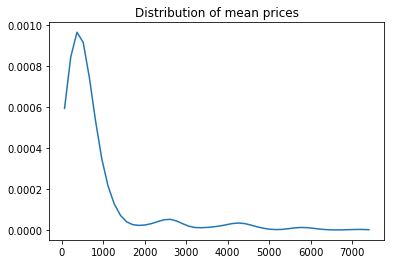

In [4]:
from scipy.stats.kde import gaussian_kde
def kde_plot(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    plt.plot(positions, smoothed)
    
def kde_values(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    return positions, smoothed

x=x.dropna()
kde_plot(x)
plt.title("Distribution of mean prices")
plt.show()

### Distribution of the difference in price

Uses the normalized data to find the distribution of price differentiation between days.
Basically, how many instances are far away from the pervious days price or close.

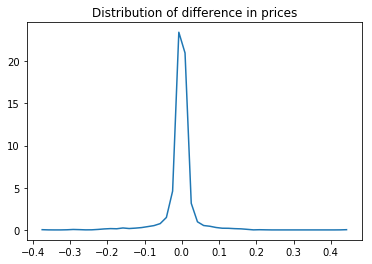

In [5]:
df = df.assign(Diff = df['normalize'].diff())
df.head()
x = df['Diff'].dropna()
kde_plot(x)
plt.title("Distribution of difference in prices")
plt.show()


### Changing outlier data
This finds the outliers that are far diffrent from the previous days and the nexts days, if they are it gets rid of the spike and finds a mean between the two

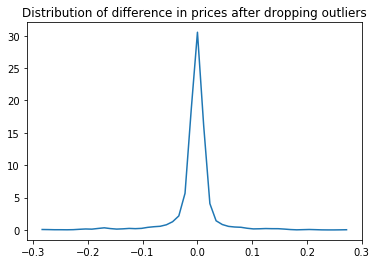

In [6]:
for y in range(len(df) - 1):
    if (df.loc[y,'Diff'] > .1 and df.loc[y+1,'Diff'] > .1) or (df.loc[y,'Diff'] < -.1 and df.loc[y+1,'Diff'] < -.1):
        df.loc[y,'Mean'] = (df.loc[y-1,'Mean'] + df.loc[y+1,'Mean']) / 2.
        df.loc[y,'High'] = (df.loc[y-1,'High'] + df.loc[y+1,'High']) / 2.
        df.loc[y,'Open'] = (df.loc[y-1,'Open'] + df.loc[y+1,'Open']) / 2.
        df.loc[y,'Close'] = (df.loc[y-1,'Close'] + df.loc[y+1,'Close']) / 2.
        df.loc[y,'Low'] = (df.loc[y-1,'Low'] + df.loc[y+1,'Low']) / 2.

df['normalize'] = preprocessing.scale(df['Mean'])
df['Diff'] = df['normalize'].diff()  
x = df['Diff'].dropna()
kde_plot(x)
plt.title("Distribution of difference in prices after dropping outliers")
plt.show()

## Processing the data
### Uses a random forest to mine the data

These results show that our random forest classifier is about 98% correct with the same dataset we passed it.

The features of this dataset correspond to each column.  These features are printed out last. These features show that Open data is more important while Close data is least important.

In [37]:
df['Class'] = df['Close'] > df['Open'] #Creates a class analysis for the data

from sklearn.ensemble import RandomForestClassifier
y=df.iloc[:,-1].fillna(df.mean()).as_matrix()
x=df.iloc[:,1:5].fillna(df.mean()).as_matrix()
rfc = RandomForestClassifier(max_depth=25, random_state=0)  #Inits rfc

print y.shape
print x.shape

x = preprocessing.StandardScaler().fit_transform(x)  #normalizes data
rfc.fit(x,y)  #Builds tree
y_pred = rfc.predict(x)    #Runs same data through tree
classif_rate = np.mean(y_pred.ravel() == y.ravel()) * 100   #Correct rate
print("classif_rate for %s : %f " % ('RandomForestClassifier', classif_rate))   
print rfc.feature_importances_   #prints the features


(1655,)
(1655, 4)
classif_rate for RandomForestClassifier : 98.368580 
[ 0.32851618  0.19046712  0.20003087  0.28098583]
